In [5]:
## IMPORT 

import os
import numpy as  np
import pylab as plt
from scipy.signal import medfilt, butter, filtfilt
from scipy.stats import linregress
from scipy.optimize import curve_fit, minimize
from scipy.signal import resample
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import h5py as h5
import h5py
from pathlib import Path
import pandas as pd
import glob
import os
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simpson
from scipy.stats import pearsonr
import matplotlib.cm as cm
from statsmodels.formula.api import mixedlm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib as mpl
## SMOOTHING
from scipy.signal import savgol_filter
from scipy.stats import ttest_ind
from matplotlib.ticker import MaxNLocator

In [6]:
# Text   
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.size'] = 20
mpl.rcParams['font.family'] = '.SF Camera'

# Boxes
mpl.rcParams['axes.spines.top']= False
mpl.rcParams['axes.spines.right']= False

# plt.rcParams['figure.figsize'] = [4, 5]
plt.rcParams['figure.dpi'] = 140


In [7]:
directory = '/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/YmazeBLA/preprocessed'

# Find all CSV files in the directory
csv_files = glob.glob(os.path.join(directory, "*.csv"))

# Initialize list to store df
df = pd.DataFrame()

# Loop through each CSV, then concatenate them into a single df
for file in csv_files:
    single = pd.read_csv(file)
    df = pd.concat([df, single], axis=0, ignore_index=True)

df

,Time,Zscoreg,Zscorer,In larm,In rarm,In Novelarm,In middle,ID,sex
0,0.087399,1.920901,0.394051,0,1,0,0,1034,M
1,0.104071,1.920901,0.394051,0,1,0,0,1034,M
2,0.120743,1.920901,0.394051,0,1,0,0,1034,M
3,0.137415,1.920901,0.394051,0,1,0,0,1034,M
4,0.154087,1.920901,0.394051,0,1,0,0,1034,M
...,...,...,...,...,...,...,...,...,...
395927,600.196277,0.386152,-0.819375,0,0,0,0,1045,F
395928,600.212952,0.387498,-0.034860,0,0,0,0,1045,F
395929,600.229628,0.404442,0.314298,0,0,0,0,1045,F
395930,600.246304,0.425539,0.299469,0,0,0,0,1045,F


In [8]:
df['In farm'] = 0
df.loc[(df['In larm'] == 1) | (df['In rarm'] == 1), 'In farm'] = 1
df

,Time,Zscoreg,Zscorer,In larm,In rarm,In Novelarm,In middle,ID,sex,In farm
0,0.087399,1.920901,0.394051,0,1,0,0,1034,M,1
1,0.104071,1.920901,0.394051,0,1,0,0,1034,M,1
2,0.120743,1.920901,0.394051,0,1,0,0,1034,M,1
3,0.137415,1.920901,0.394051,0,1,0,0,1034,M,1
4,0.154087,1.920901,0.394051,0,1,0,0,1034,M,1
...,...,...,...,...,...,...,...,...,...,...
395927,600.196277,0.386152,-0.819375,0,0,0,0,1045,F,0
395928,600.212952,0.387498,-0.034860,0,0,0,0,1045,F,0
395929,600.229628,0.404442,0.314298,0,0,0,0,1045,F,0
395930,600.246304,0.425539,0.299469,0,0,0,0,1045,F,0


In [9]:
polyorder = 2  # Polynomial order
window_length = 21  # Window length: must be an odd number

# Group by ID and day, then apply the Savitzky-Golay filter
df['Zscoreg'] = df.groupby(['ID'])['Zscoreg'].transform(lambda x: savgol_filter(x, window_length, polyorder))

      ID    latency
0   1034   2.333333
1    129   1.816667
2   1051   7.333333
3   1052  12.366667
4    116   2.116667
5   1050  24.450000
6    118   1.966667
7   1035   5.516667
8   1028   6.733333
9   1046   2.900000
10  1045   0.900000


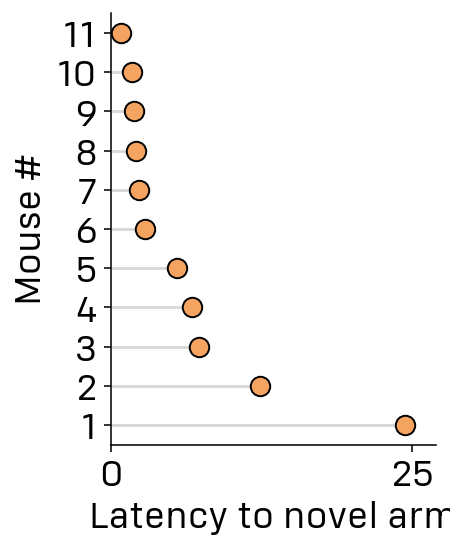

In [10]:
# GET PRE NOVEL ARM DATA ->>>> Latency to enter the novelarm, defined as time to enter novelarm since last exit from familiar
pre_dfs = []

for mouse in df['ID'].unique():
    # Filter the dataframe for the current ID
    group = df[df['ID'] == mouse].reset_index(drop=True)
    
    # Find the index of the first occurrence of In Novelarm = 1
    idx = group[group['In Novelarm'] == 1].index[0]
    
    # Select all rows after this index
    filtered_group = group.loc[:idx].copy()
    lastexit = filtered_group.loc[(filtered_group['In farm'].shift() == 1) & (filtered_group['In farm'] == 0)].index[-1]
    filtered_group['lastexit']=0
    filtered_group.loc[lastexit,'lastexit']=1

    
    # Append the filtered group to the list
    pre_dfs.append(filtered_group)

# Concatenate all filtered dataframes
predf = pd.concat(pre_dfs, axis=0, ignore_index=True)

latencydic={'ID':[], 'latency':[]}
for mouse in predf['ID'].unique():
    mouse_df = predf[predf['ID'] == mouse]
    latency=mouse_df.loc[mouse_df['lastexit']==1].index[0]-mouse_df.loc[mouse_df['In Novelarm']==1].index[0]
    latencydic['ID'].append(mouse)
    latencydic['latency'].append(abs(latency/60))
latencydf=pd.DataFrame(latencydic)
print(latencydf)

#plotting

latencydf = latencydf.sort_values('latency', ascending=False).reset_index(drop=True)


plt.figure(figsize=(3, 4))


plt.scatter(latencydf['latency'], latencydf.index, alpha=1, color='sandybrown', s=100, edgecolor='black', zorder=1) 
for mouse in latencydf['ID']:
    plt.hlines(y=latencydf[latencydf['ID'] == mouse].index[0], xmin=0, xmax=latencydf[latencydf['ID'] == mouse]['latency'].iloc[0], 
               colors='gray', alpha= 0.3,zorder=0)

plt.xlim(0, 27)
plt.xticks(ticks=([0,25]))
plt.yticks(ticks=latencydf.index, labels=(latencydf.index)+1)
plt.ylabel('Mouse #')
plt.xlabel('Latency to novel arm')
# plt.savefig(f'/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/YmazeBLA/figures/latency.pdf', format='pdf')
plt.show()




In [11]:
# #only take into consideration signal after the first novelarm=1 
full_df = df.copy()
filtered_dfs = []

for mouse in df['ID'].unique():
    # Filter the dataframe for the current ID
    group = df[df['ID'] == mouse]
    
    # Find the index of the first occurrence of In Novelarm = 1
    idx = group[group['In Novelarm'] == 1].index[0]
    
    # Select all rows after this index
    filtered_group = group.loc[idx:]
    
    # Append the filtered group to the list
    filtered_dfs.append(filtered_group)

# Concatenate all filtered dataframes
df = pd.concat(filtered_dfs, axis=0, ignore_index=True)

180.0
180.0
180.0
180.0
180.0
180.0
180.0
153.13333333333333
180.0
180.0
180.0
      ID    Condition  proportion_time
0   1034      In farm        33.473054
1   1034  In Novelarm        66.526946
2    129      In farm        59.331406
3    129  In Novelarm        40.668594
4   1051      In farm        41.673027
5   1051  In Novelarm        58.326973
6   1052      In farm        33.271144
7   1052  In Novelarm        66.728856
8    116      In farm        41.056279
9    116  In Novelarm        58.943721
10  1050      In farm        40.927896
11  1050  In Novelarm        59.072104
12   118      In farm        50.590914
13   118  In Novelarm        49.409086
14  1035      In farm        21.248952
15  1035  In Novelarm        78.751048
16  1028      In farm        46.953360
17  1028  In Novelarm        53.046640
18  1046      In farm        26.627643
19  1046  In Novelarm        73.372357
20  1045      In farm        41.947164
21  1045  In Novelarm        58.052836
Shapiro-Wilk test result

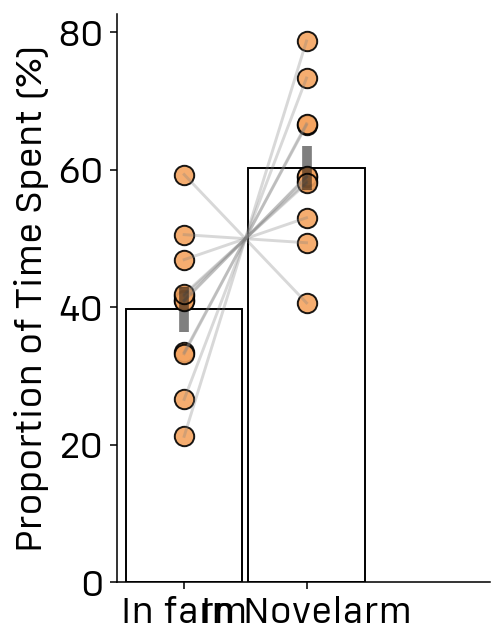

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ttest_rel, shapiro

def plot_proportion_time_with_ttest(df):
    # Lists to store the time spent for each condition (per mouse)
    mouse_time_values = {'ID': [], 'Condition': [], 'proportion_time': []}
    
    # Loop through each mouse
    for mouse in df['ID'].unique():
        # Filter the data for the current mouse
        mouse_data = df[df['ID'] == mouse].reset_index(drop=True)
        mouse_data = mouse_data.iloc[:3*60*60] # 3 minutes
        print(len(mouse_data)/60)
        # Calculate total time spent
        total_time_spent = len(mouse_data[(mouse_data['In farm']==1) | (mouse_data['In Novelarm']==1)]) / 60  # Assuming 60 Hz sampling rate
        
        # For each compartment (condition), calculate time spent
        for condition, condition_column in zip(['In farm', 'In Novelarm'], 
                                                ['In farm', 'In Novelarm']):
            
            # Filter data where the mouse was in the current condition (column value = 1)
            condition_data = mouse_data[mouse_data[condition_column] == 1]

            # Calculate time spent in the compartment (number of samples, converted to seconds)
            time_spent = len(condition_data) / 60  # Assuming 60 Hz sampling rate
            
            # Calculate proportion of time spent
            proportion_time = (time_spent / total_time_spent) * 100
            
            # Append the values
            mouse_time_values['ID'].append(mouse)
            mouse_time_values['Condition'].append(condition)
            mouse_time_values['proportion_time'].append(proportion_time)

    # Convert to DataFrame
    proportion_time_df = pd.DataFrame(mouse_time_values)
    print(proportion_time_df)
    
    # Perform Shapiro-Wilk test for normality
    conditions = ['In farm', 'In Novelarm']
    condition_data = {condition: proportion_time_df[proportion_time_df['Condition'] == condition]['proportion_time'] for condition in conditions}
    shapiro_results = {condition: shapiro(condition_data[condition]) for condition in conditions}
    print(f"Shapiro-Wilk test results: {shapiro_results}")
    
    # Perform paired t-test for paired samples
    ttest_results = ttest_rel(condition_data[conditions[0]], condition_data[conditions[1]])
    print(f"Paired t-test results: {ttest_results}")
    
    # Plot the proportion of time spent for each mouse (individual values)
    plt.figure(figsize=(4,5))
    for condition in conditions:
        # Plot the individual proportion of time spent for each mouse
        plt.scatter(
            np.repeat(condition, len(proportion_time_df[proportion_time_df['Condition'] == condition])), 
            proportion_time_df[proportion_time_df['Condition'] == condition]['proportion_time'], 
            alpha=0.9, color='sandybrown', edgecolor='black', s=100)
    
    # Add lines connecting individual data points by ID
    for mouse in proportion_time_df['ID'].unique():
        mouse_data = proportion_time_df[proportion_time_df['ID'] == mouse]
        plt.plot(mouse_data['Condition'], mouse_data['proportion_time'], 
                 color='grey', alpha=0.3)
    
    # Calculate means and SEM
    means = proportion_time_df.groupby('Condition')['proportion_time'].mean()
    sems = proportion_time_df.groupby('Condition')['proportion_time'].sem()
    
    # Plot the average proportion of time spent for each condition with SEM
    plt.bar(means.index, means, yerr=sems, capsize=0, color='none', alpha=1, edgecolor='black', 
        label='Mean proportion of time spent', width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
        zorder=0)
    
    # Add labels and title
    plt.ylabel('Proportion of Time Spent (%)')

    #misc 
    ax = plt.gca()  # Get the current axis
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
    ax.set_xlim(-0.55,3-0.5)
    plt.tight_layout()

    # Show the plot
    #plt.savefig(f'/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/YmazeBLA/figures/Ymaze_proportion_time_spent.pdf', format='pdf')
    plt.show()

    return proportion_time_df, shapiro_results, ttest_results

proportion_time_df, shapiro_results, ttest_results = plot_proportion_time_with_ttest(df)


Wilcoxon signed-rank test results: WilcoxonResult(statistic=0.0, pvalue=0.0009765625)


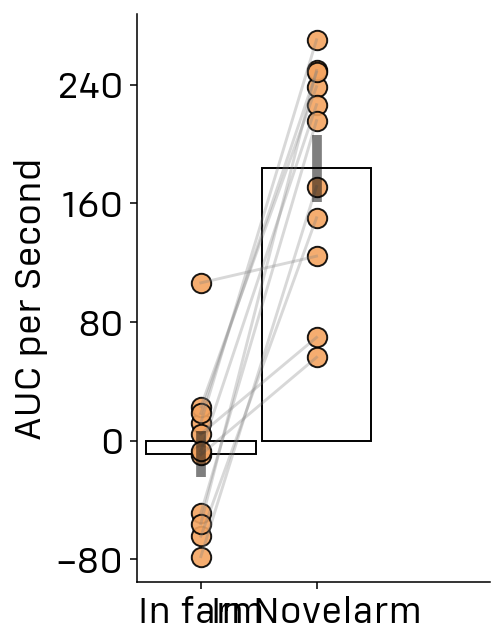

      ID    Condition  AUC_per_sec
0   1034      In farm    12.181880
1   1034  In Novelarm   270.315973
2    129      In farm    22.934474
3    129  In Novelarm   238.714572
4   1051      In farm    -9.460060
5   1051  In Novelarm    56.173202
6   1052      In farm   -78.176305
7   1052  In Novelarm   171.340436
8    116      In farm   106.420160
9    116  In Novelarm   124.418106
10  1050      In farm     4.508431
11  1050  In Novelarm    69.605469
12   118      In farm    -7.017509
13   118  In Novelarm   226.558087
14  1035      In farm   -48.914258
15  1035  In Novelarm   215.833573
16  1028      In farm   -64.411219
17  1028  In Novelarm   150.285043
18  1046      In farm   -55.994809
19  1046  In Novelarm   249.664719
20  1045      In farm    18.391033
21  1045  In Novelarm   248.459452


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon

def plot_auc_per_second_with_wilcoxon(df):
    # Lists to store the AUC per second for each condition (per mouse)
    mouse_auc_values = {'ID': [], 'Condition': [], 'AUC_per_sec': []}
    
    # Loop through each mouse
    for mouse in df['ID'].unique():
        # Filter the data for the current mouse
        mouse_data = df[df['ID'] == mouse]
        
        # For each compartment (condition), calculate AUC and time spent
        for condition, condition_column in zip(['In farm', 'In Novelarm'], 
                                                ['In farm', 'In Novelarm']):
            
            # Filter data where the mouse was in the current condition (column value = 1)
            condition_data = mouse_data[mouse_data[condition_column] == 1]

            #### ONLY KEEP THE FIRST 10 SECS OF THE ITERATED CONDITION TO COMPARE

            condition_data = condition_data.iloc[:600]

            
            # Calculate time spent in the compartment (number of samples, converted to seconds)
            time_spent = len(condition_data) / 60  # Assuming 60 Hz sampling rate
            
            # Skip conditions where time spent is less than 5 seconds
            if time_spent < 5:
                continue
            
            # Calculate AUC for the condition by summing Zscoreg in the time the mouse was in this compartment
            auc = condition_data['Zscoreg'].sum()
            
            # AUC per second for the condition
            auc_per_sec = auc / time_spent
            
            # Append the values
            mouse_auc_values['ID'].append(mouse)
            mouse_auc_values['Condition'].append(condition)
            mouse_auc_values['AUC_per_sec'].append(auc_per_sec)
    
    # Convert to DataFrame
    auc_per_sec_df = pd.DataFrame(mouse_auc_values)
    
    # Perform Wilcoxon signed-rank test for paired samples
    conditions = ['In farm', 'In Novelarm']
    condition_data = {condition: auc_per_sec_df[auc_per_sec_df['Condition'] == condition]['AUC_per_sec'] for condition in conditions}
    wilcoxon_results = wilcoxon(condition_data[conditions[0]], condition_data[conditions[1]])
    print(f"Wilcoxon signed-rank test results: {wilcoxon_results}")
    
    # Plot the AUC per second for each mouse (individual values)
    plt.figure(figsize=(4,5))
    for condition in conditions:
        # Plot the individual AUC per second for each mouse
        plt.scatter(
            np.repeat(condition, len(auc_per_sec_df[auc_per_sec_df['Condition'] == condition])), 
            auc_per_sec_df[auc_per_sec_df['Condition'] == condition]['AUC_per_sec'], 
            alpha=0.9, color='sandybrown', edgecolor='black', s=100)
    
    # Add lines connecting individual data points by ID
    for mouse in auc_per_sec_df['ID'].unique():
        mouse_data = auc_per_sec_df[auc_per_sec_df['ID'] == mouse]
        plt.plot(mouse_data['Condition'], mouse_data['AUC_per_sec'], 
                 color='grey', alpha=0.3)
    
    # Calculate means and SEM
    means = auc_per_sec_df.groupby('Condition')['AUC_per_sec'].mean()
    sems = auc_per_sec_df.groupby('Condition')['AUC_per_sec'].sem()
    
    # Plot the average AUC per second for each condition with SEM
    plt.bar(means.index, means, yerr=sems, capsize=0, color='none', alpha=1, edgecolor='black', 
        label='Mean AUC per second', width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
        zorder=0)
    
    # Add labels and title
    plt.ylabel('AUC per Second')


    #misc 
    ax = plt.gca()  # Get the current axis
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
    ax.set_xlim(-0.55,3-0.5)
    plt.tight_layout()

    
    # Show the plot
    # plt.savefig(f'/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/YmazeBLA/figures/AUC.pdf', format='pdf')
    plt.show()
    # Show the plot
    plt.show()

    return auc_per_sec_df, wilcoxon_results

# Example usage:
# Call the function to calculate and plot AUC per second for each condition, and perform Wilcoxon signed-rank test
auc_per_sec_df, wilcoxon_results = plot_auc_per_second_with_wilcoxon(df)
print(auc_per_sec_df)

pvalue : 0.02747791283354771, r squared : 0.4340673626294437


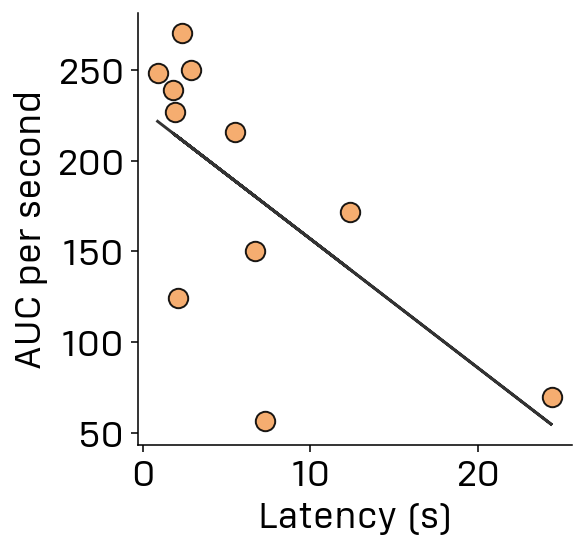

In [14]:
### CORR LATENCY TO ENTER NOVELARM AND AUC PER SEC 

aucdf = auc_per_sec_df[auc_per_sec_df['Condition'] == 'In Novelarm']
corr = pd.merge(aucdf, latencydf, on='ID')

#linreg
slope, intercept, r_value, p_value, std_err = linregress(corr['latency'], corr['AUC_per_sec'])

#plotting

plt.figure(figsize=(4, 4))

plt.plot(corr['latency'], intercept + slope * corr['latency'], color='black', alpha=0.8, zorder=0)
plt.scatter(corr['latency'], corr['AUC_per_sec'], alpha=0.9, color='sandybrown', edgecolor='black', s=100)
print(f'pvalue : {p_value}, r squared : {r_value**2}')
plt.xlabel('Latency (s)')
plt.ylabel('AUC per second')
#plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/YmazeBLA/figures/corrLatencyAUC.pdf', format='pdf')
plt.show()

Wilcoxon signed-rank test results for sex M: WilcoxonResult(statistic=0.0, pvalue=0.0625)
Wilcoxon signed-rank test results for sex F: WilcoxonResult(statistic=0.0, pvalue=0.03125)


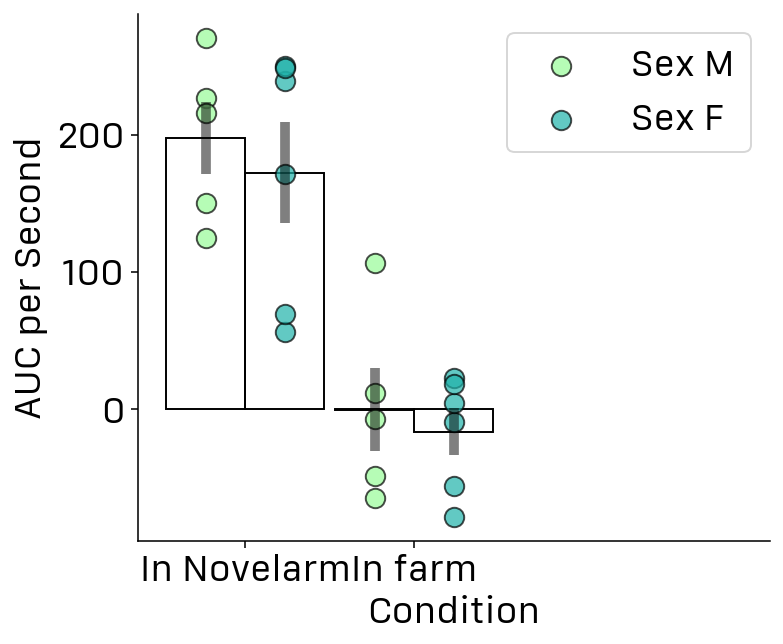

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import wilcoxon
from matplotlib.ticker import MaxNLocator

def plot_auc_per_second_with_wilcoxon_per_sex(df):
    # Lists to store the AUC per second for each condition (per mouse)
    mouse_auc_values = {'ID': [], 'Condition': [], 'AUC_per_sec': [], 'sex': []}
    
    # Loop through each mouse
    for mouse in df['ID'].unique():
        # Filter the data for the current mouse
        mouse_data = df[df['ID'] == mouse]
        
        # For each compartment (condition), calculate AUC and time spent
        for condition, condition_column in zip(['In farm', 'In Novelarm'], 
                                                ['In farm', 'In Novelarm']):
            
            # Filter data where the mouse was in the current condition (column value = 1)
            condition_data = mouse_data[mouse_data[condition_column] == 1]

            #### ONLY KEEP THE FIRST 10 SECS OF THE ITERATED CONDITION TO COMPARE
            condition_data = condition_data.iloc[:600]
            
            # Calculate time spent in the compartment (number of samples, converted to seconds)
            time_spent = len(condition_data) / 60  # Assuming 60 Hz sampling rate
            
            # Skip conditions where time spent is less than 10 seconds
            if time_spent < 10:
                continue
            
            # Calculate AUC for the condition by summing Zscoreg in the time the mouse was in this compartment
            auc = condition_data['Zscoreg'].sum()
            
            # AUC per second for the condition
            auc_per_sec = auc / time_spent
            
            # Append the values
            mouse_auc_values['ID'].append(mouse)
            mouse_auc_values['Condition'].append(condition)
            mouse_auc_values['AUC_per_sec'].append(auc_per_sec)
            mouse_auc_values['sex'].append(mouse_data['sex'].iloc[0])
    
    # Convert to DataFrame
    auc_per_sec_df = pd.DataFrame(mouse_auc_values)
    
    # Perform Wilcoxon signed-rank test for paired samples, separated by sex
    conditions = ['In Novelarm', 'In farm']
    sexes = ['M', 'F']
    wilcoxon_results = {}
    for sex in sexes:
        condition_data = {condition: auc_per_sec_df[(auc_per_sec_df['Condition'] == condition) & (auc_per_sec_df['sex'] == sex)]['AUC_per_sec'] for condition in conditions}
        wilcoxon_results[sex] = wilcoxon(condition_data[conditions[0]], condition_data[conditions[1]])
        print(f"Wilcoxon signed-rank test results for sex {sex}: {wilcoxon_results[sex]}")
    
    # Plot the AUC per second for each mouse (individual values)
    plt.figure(figsize=(6, 5))
    bar_width = 0.35
    index = np.arange(len(conditions)) * (0.4 + bar_width)  # Adjust spacing between bars

    for i, sex in enumerate(sexes):
        means = auc_per_sec_df[auc_per_sec_df['sex'] == sex].groupby('Condition')['AUC_per_sec'].mean()
        sems = auc_per_sec_df[auc_per_sec_df['sex'] == sex].groupby('Condition')['AUC_per_sec'].sem()
        plt.bar(index + i * bar_width, means, bar_width, yerr=sems, capsize=0,error_kw=dict(lw=5, alpha=0.5, zorder=4),
                 edgecolor='black', color='none')

    # Add individual data points
    for i, sex in enumerate(sexes):
        for condition in conditions:
            condition_data = auc_per_sec_df[(auc_per_sec_df['Condition'] == condition) & (auc_per_sec_df['sex'] == sex)]
            color = 'palegreen' if sex == 'M' else 'lightseagreen'
            plt.scatter(np.repeat(index[conditions.index(condition)] + i * bar_width, len(condition_data)), 
                        condition_data['AUC_per_sec'], alpha=0.7, edgecolor='black', s=100, color=color, label=f'Sex {sex}' if condition == 'In farm' else "")

    plt.xlabel('Condition')
    plt.ylabel('AUC per Second')
    plt.xticks(index + bar_width / 2, conditions)
    plt.xlim((-0.3, 3 - 0.5))
    plt.legend()
    plt.tight_layout()

    # Show the plot
    # plt.savefig(f'/Users/ossamaghenissa/Desktop/anxietypaper/figures/sexdifferences/YmazeAUC.pdf', format='pdf')
    plt.show()

    return auc_per_sec_df, wilcoxon_results

# Example usage:
# Call the function to calculate and plot AUC per second for each condition, separated by sex, and perform Wilcoxon signed-rank test
auc_per_sec_df, wilcoxon_results = plot_auc_per_second_with_wilcoxon_per_sex(df)


In [16]:
#IN NOVELARN TOTAL : TO GET THE FIRST 3 EXPLORATION THAT LASTED MORE THAN 5 SECONDS

### MSU BE ON FULL_DF

# Parameters
sampling_rate = 60
min_closedarms_rows = 5 * sampling_rate  # Convert time to rows
min_after_rows = 5 * sampling_rate      # Convert time to rows

# Initialize list to store processed mouse data
processed_mouse_data = []

for mouse in full_df['ID'].unique():
    # Filter the data for the current mouse
    mouse_data = full_df[full_df['ID'] == mouse].reset_index(drop=True)
    
    # Create a boolean mask where 'In Closed Arms' is 1 for the current mouse
    closed_arms_mask = mouse_data['In Novelarm'] == 1
    
    # Identify indices where 'In Closed Arms' transitions from 0 to 1
    transition_indices = closed_arms_mask[(closed_arms_mask.shift() == 0) & (closed_arms_mask == 1)].index
    end_indices = closed_arms_mask[(closed_arms_mask.shift() == 1) & (closed_arms_mask == 0)].index

    # Iterate through transition indices
    valid_count = 0
    for transition_index, end_index in zip(transition_indices, end_indices):
        if valid_count >= 3:
            break
        # Define start and end indices for checks
        preceding_start_index = max(0, transition_index - min_closedarms_rows)
        following_end_index = min(len(mouse_data), transition_index + min_after_rows)
        
        # Get preceding and following rows
        preceding_rows = mouse_data.loc[preceding_start_index:transition_index - 1, 'In Novelarm']
        following_rows = mouse_data.loc[transition_index:following_end_index - 1, 'In Novelarm']
        following_farmrows = mouse_data.loc[transition_index:following_end_index - 1, 'In farm']

        # Check if conditions are satisfied
        if preceding_rows.eq(0).mean() >= 0.8 and following_rows.eq(1).mean() >= 0.8 and following_farmrows.eq(0).mean() >= 1:
            mouse_data.loc[transition_index, 'valid_transition'] = 1
            valid_count += 1
            mouse_data.loc[transition_index:end_index, 'transition_number'] = valid_count
            
        else:
            print(f"Transition at index {transition_index} for mouse {mouse} skipped due to unmet conditions.")

    
    
    # Append the processed mouse data to the list
    processed_mouse_data.append(mouse_data)

# Concatenate all processed mouse data into a single DataFrame
threefirstexplorationdf = pd.concat(processed_mouse_data, ignore_index=True)

# Display results
print(threefirstexplorationdf['valid_transition'].value_counts())
# print(df)

Transition at index 23846 for mouse 1034 skipped due to unmet conditions.
Transition at index 23767 for mouse 1051 skipped due to unmet conditions.
Transition at index 25174 for mouse 1051 skipped due to unmet conditions.
Transition at index 24527 for mouse 1052 skipped due to unmet conditions.
Transition at index 27239 for mouse 116 skipped due to unmet conditions.
Transition at index 27291 for mouse 116 skipped due to unmet conditions.
Transition at index 27441 for mouse 1035 skipped due to unmet conditions.
Transition at index 29242 for mouse 1035 skipped due to unmet conditions.
Transition at index 31223 for mouse 1035 skipped due to unmet conditions.
Transition at index 22934 for mouse 1028 skipped due to unmet conditions.
Transition at index 23348 for mouse 1046 skipped due to unmet conditions.
valid_transition
1.0    33
Name: count, dtype: int64


/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/ossamaghenissa/miniconda3/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


              Mixed Linear Model Regression Results
Model:                MixedLM   Dependent Variable:   AUC_per_sec
No. Observations:     33        Method:               REML       
No. Groups:           11        Scale:                2771.2170  
Min. group size:      3         Log-Likelihood:       -165.1429  
Max. group size:      3         Converged:            Yes        
Mean group size:      3.0                                        
-----------------------------------------------------------------
                  Coef.   Std.Err.   z    P>|z|  [0.025   0.975] 
-----------------------------------------------------------------
Intercept         195.750   15.911 12.303 0.000  164.565  226.934
Condition[T.2.0] -212.674   22.447 -9.475 0.000 -256.669 -168.680
Condition[T.3.0] -204.126   22.447 -9.094 0.000 -248.121 -160.131
Group Var          13.458   16.710                               

   Multiple Comparison of Means - Tukey HSD, FWER=0.05   
group1 group2  meandiff p-adj  

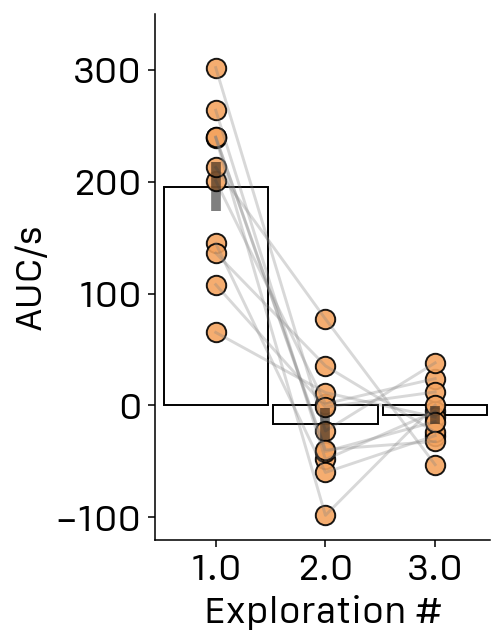

In [17]:
## BARPLOT EXPLORATION NUMBERRRRRR 

def plot_auc_per_second(df):
    # Lists to store the AUC per second for each condition (per mouse)
    mouse_auc_values = {'ID': [], 'Condition': [], 'AUC_per_sec': []}
    
    # Loop through each mouse
    for mouse in df['ID'].unique():
        # Filter the data for the current mouse
        mouse_data = df[df['ID'] == mouse]
        
        # For each compartment (condition), calculate AUC and time spent
        for condition in df['transition_number'].dropna().unique():
            
            # Filter data where the mouse was in the current condition (column value = 1)
            condition_data = mouse_data[mouse_data['transition_number'] == condition]

            #### ONLY KEEP THE FIRST 10 SECS OF THE ITERATED CONDITION TO COMPARE

            # Calculate time spent in the compartment (number of samples, converted to seconds)
            time_spent = len(condition_data) / 60  # Assuming 60 Hz sampling rate
            
            # Calculate AUC for the condition by summing Zscoreg in the time the mouse was in this compartment
            auc = condition_data['Zscoreg'].sum()
            
            # AUC per second for the condition
            auc_per_sec = auc / time_spent
            
            # Append the values
            mouse_auc_values['ID'].append(mouse)
            mouse_auc_values['Condition'].append(condition)
            mouse_auc_values['AUC_per_sec'].append(auc_per_sec)
    
    # Convert to DataFrame
    auc_per_sec_df = pd.DataFrame(mouse_auc_values)
    auc_per_sec_df['Condition'] = auc_per_sec_df['Condition'].astype(str) 


    model = mixedlm("AUC_per_sec ~ Condition", auc_per_sec_df, groups=auc_per_sec_df["ID"])
    mixedlm_results = model.fit()
    print(mixedlm_results.summary())

    
    # Perform post-hoc pairwise comparisons using Tukey's HSD
    tukey = pairwise_tukeyhsd(auc_per_sec_df['AUC_per_sec'], auc_per_sec_df['Condition'])
    print(tukey)
    conditions = df['transition_number'].dropna().unique().astype(str)

    # Plot the AUC per second for each mouse (individual values)
    plt.figure(figsize=(4,5))
    for condition in conditions:
        # Plot the individual AUC per second for each mouse
        plt.scatter(
            np.repeat(condition, len(auc_per_sec_df[auc_per_sec_df['Condition'] == condition])), 
            auc_per_sec_df[auc_per_sec_df['Condition'] == condition]['AUC_per_sec'], 
            alpha=0.9, color='sandybrown', edgecolor='black', s=100)
    
    # Add lines connecting individual data points by ID
    for mouse in auc_per_sec_df['ID'].unique():
        mouse_data = auc_per_sec_df[auc_per_sec_df['ID'] == mouse]
        plt.plot(mouse_data['Condition'], mouse_data['AUC_per_sec'], 
                 color='grey', alpha=0.3)
    
    # Calculate means and SEM
    means = auc_per_sec_df.groupby('Condition')['AUC_per_sec'].mean()
    print(means)
    sems = auc_per_sec_df.groupby('Condition')['AUC_per_sec'].sem()
    print(means)
    # Plot the average AUC per second for each condition with SEM
    plt.bar(means.index, means, yerr=sems, capsize=0, color='none', alpha=1, edgecolor='black', 
        label='Mean AUC per second', width=0.95, error_kw=dict(lw=5, alpha=0.5, zorder=4),
        zorder=0)
    
    # Add labels and title
    plt.ylabel('AUC/s')
    plt.xlabel('Exploration #')

    # Set y-axis limits
    

    #misc 
    ax = plt.gca()  # Get the current axis
    ax.yaxis.set_major_locator(MaxNLocator(nbins=5))  # Set max ticks to 4
    ax.set_xlim(-.55,3-0.5)
    ax.set_ylim(-120, 350)
     # Set y-ticks with the last tick at 350
    
    plt.tight_layout()

    
    # Show the plot
    #plt.savefig(f'/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/YmazeBLA/figures/AUCNovelobjectpertransition.pdf', format='pdf')
    plt.show()
    # Show the plot
    plt.show()

    return auc_per_sec_df, wilcoxon_results

# Example usage:
# Call the function to calculate and plot AUC per second for each condition, and perform Wilcoxon signed-rank test
auc_per_sec_df, wilcoxon_results = plot_auc_per_second(threefirstexplorationdf)



In [18]:
# FIRST NOVEL ARM EXPLORATION 
## MUST BE DONE ON FULL_DF BC CUT DF DOESN'T HAVE TEH FIRST 0 - 1 transition novel arm 
# Parameters
sampling_rate = 60
min_closedarms_rows = 5 * sampling_rate  # Convert time to rows
min_after_rows = 10 * sampling_rate      # Convert time to rows

# Initialize list to store processed mouse data
processed_mouse_data = []

for mouse in df['ID'].unique():
    # Filter the data for the current mouse
    mouse_data = df[df['ID'] == mouse].reset_index(drop=True)
    
    # Create a boolean mask where 'In Novelarm' is 1 for the current mouse
    novel_arm_mask = mouse_data['In Novelarm'] == 1
    
    # Identify indices where 'In Novelarm' transitions from 0 to 1
    transition_indices = novel_arm_mask[(novel_arm_mask.shift() == 0) & (novel_arm_mask == 1)].index
    
    if not transition_indices.empty:
        # Get the first transition index
        first_transition_index = transition_indices[0]
        mouse_data.loc[first_transition_index, 'valid_transition'] = 1
    
    # Append the processed mouse data to the list
    processed_mouse_data.append(mouse_data)

# Concatenate all processed mouse data into a single DataFrame
df = pd.concat(processed_mouse_data, ignore_index=True)

# Display results
print(df['valid_transition'].value_counts())

valid_transition
1.0    11
Name: count, dtype: int64


In [19]:
# Pre-tone and post-tone window settings
pre_tone = -5
post_tone = 10
sampling_freq = 60

presample = int(abs(pre_tone * sampling_freq))  # Number of samples before the tone
postsample = int(abs(post_tone * sampling_freq))  # Number of samples after the tone

total_samples = presample + postsample + 1  # Total samples from -5 to 10 seconds

# Create empty list to store processed dataframes
processed_dfs = []

# Iterate through each mouse
for mouse in df['ID'].unique():
    # Filter for the current mouse
    mousedf = df[df['ID'] == mouse].reset_index(drop=True)

    # Identify onset indices of valid transitions
    onset_indices = mousedf[mousedf['valid_transition'] == 1].index

    for t, onset_idx in enumerate(onset_indices):
        start_idx = onset_idx - presample
        end_idx = onset_idx + postsample

        # Ensure indices stay within bounds and length matches total_samples
        if start_idx >= 0 and end_idx < len(mousedf) and (end_idx - start_idx + 1) == total_samples:
            # Generate the time vector
            time_vector = np.linspace(pre_tone, post_tone, total_samples)

            # Assign the time vector and exploration number
            mousedf.loc[start_idx:end_idx, 'time_vector'] = time_vector
            mousedf.loc[start_idx:end_idx, 'exploration'] = 1
            mousedf.loc[start_idx:end_idx, 'explorationnumber'] = t + 1  # Start from 1
            print(f'ok {t + 1} for mouse {mouse}')
        else:
            print(f"Transition {t + 1} for mouse {mouse} skipped due to boundary conditions.")

    # Append the processed mouse DataFrame to the list
    processed_dfs.append(mousedf)

# Concatenate all processed DataFrames
df = pd.concat(processed_dfs, ignore_index=True)

# Display the updated DataFrame
print(df['explorationnumber'].unique())

ok 1 for mouse 1034
ok 1 for mouse 129
ok 1 for mouse 1051
ok 1 for mouse 1052
ok 1 for mouse 116
ok 1 for mouse 1050
ok 1 for mouse 118
ok 1 for mouse 1035
ok 1 for mouse 1028
ok 1 for mouse 1046
ok 1 for mouse 1045
[nan  1.]


In [20]:
# # Normalize Zscoreg for each exploration number for each mouse
# for mouse_id in df['ID'].unique():
#     # Filter for the current mouse
#     mouse_data = df[df['ID'] == mouse_id]
    
#     # Loop through each exploration number for the current mouse
#     for explo_num in mouse_data['explorationnumber'].unique():
#         # Filter for the current exploration number
#         explo_data = mouse_data[mouse_data['explorationnumber'] == explo_num]
        
#         # Identify pre-event period (before exploration, i.e., before time_vector = 0)
#         pre_event_data = explo_data[explo_data['time_vector'] < 0]
        
#         # Compute the mean Z-score for the pre-event period
#         pre_event_mean = pre_event_data['Zscoreg'].mean()
        
#         # Normalize the Zscoreg by subtracting the pre-event mean
#         df.loc[explo_data.index, 'Zscoreg'] -= pre_event_mean

# # Now `df['Zscoreg']` will be normalized for each exploration number for each mouse
# print(df)

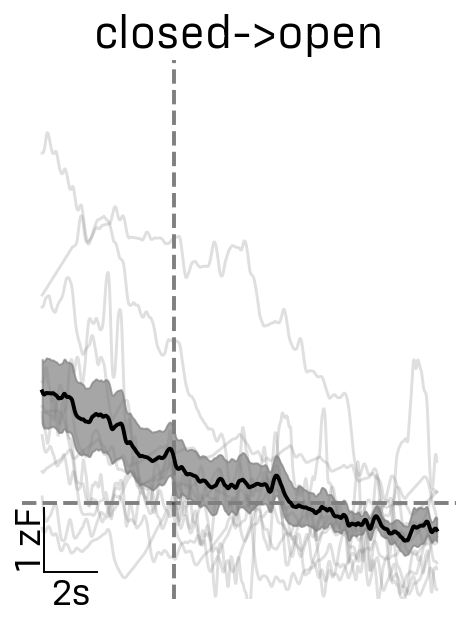

time_vector,-5.000000,-4.983333,-4.966667,-4.950000,-4.933333,-4.916667,-4.900000,-4.883333,-4.866667,-4.850000,...,9.850000,9.866667,9.883333,9.900000,9.916667,9.933333,9.950000,9.966667,9.983333,10.000000
Zscoreg,1.070453,1.024472,0.976764,0.930721,0.889787,0.856235,0.831046,0.814555,0.806697,0.806730,...,0.199714,0.212686,0.218448,0.217657,0.211850,0.203272,0.194528,0.187426,0.181649,0.175062
Zscoreg,0.503543,0.490992,0.489116,0.493483,0.501305,0.511298,0.522410,0.532992,0.541501,0.547665,...,-0.492219,-0.484789,-0.477360,-0.469930,-0.462501,-0.455072,-0.447643,-0.440214,-0.432785,-0.425355
Zscoreg,1.377381,1.323329,1.288038,1.256226,1.221467,1.188722,1.162834,1.140979,1.115231,1.077854,...,0.267498,0.325287,0.411871,0.516768,0.622251,0.710804,0.766735,0.776798,0.738332,0.664475
Zscoreg,3.286297,3.297223,3.308148,3.319074,3.330000,3.340925,3.351851,3.362777,3.373702,3.384628,...,0.003350,-0.024053,-0.048410,-0.069723,-0.089639,-0.110848,-0.135480,-0.164546,-0.198588,-0.238000
Zscoreg,1.430689,1.430923,1.430628,1.430232,1.430012,1.430138,1.430744,1.431965,1.433937,1.436687,...,0.114815,0.122562,0.130341,0.138151,0.146161,0.154617,0.163547,0.172505,0.180753,0.187720
Zscoreg,1.919432,1.906795,1.906819,1.923020,1.953133,1.991035,2.034001,2.082097,2.127083,2.149980,...,-1.252830,-1.151065,-1.070980,-1.028301,-1.016556,-1.015215,-1.008799,-0.999811,-1.002404,-1.028648
Zscoreg,-0.391606,-0.418326,-0.439604,-0.452393,-0.457514,-0.457656,-0.454365,-0.447166,-0.435279,-0.419731,...,-0.620737,-0.626990,-0.633355,-0.638133,-0.639965,-0.638507,-0.634402,-0.628916,-0.623650,-0.620024
Zscoreg,5.525641,5.526248,5.529759,5.540436,5.561400,5.592618,5.631950,5.676950,5.724914,5.771782,...,-0.850474,-0.880240,-0.900141,-0.909764,-0.912461,-0.912808,-0.913695,-0.916887,-0.924747,-0.938623
Zscoreg,3.097230,3.099246,3.105399,3.119156,3.140764,3.167410,3.194817,3.218702,3.235977,3.246227,...,-1.087509,-1.114258,-1.148561,-1.189367,-1.234100,-1.278038,-1.315495,-1.342213,-1.356401,-1.358780
Zscoreg,1.530550,1.526861,1.522825,1.514027,1.499388,1.482056,1.467144,1.457924,1.453523,1.450326,...,-0.571848,-0.567808,-0.562704,-0.557036,-0.551199,-0.545759,-0.541181,-0.536949,-0.531628,-0.524464


In [21]:

def plot_peth(df):

    plt.figure(figsize=(4,5))
    # List to store the PETH for each mouse
    mouse_average = []
    
    # Loop through each mouse
    for mouse in df['ID'].unique():
        # Filter the data for the current mouse
        mouse_data = df[df['ID'] == mouse]
        
        # Group by 'time_vector' and calculate the mean Z-score for each time point
        zscore_grouped = mouse_data.groupby('time_vector')['Zscoreg'].mean()
        
        # Plot individual mouse PETH (gray trace)
        plt.plot(zscore_grouped.index, zscore_grouped, alpha=0.25, color='gray')
        
        # Append to the list of mouse averages
        mouse_average.append(zscore_grouped)
    
    # Convert list of individual averages into a DataFrame
    mouse_average_df = pd.DataFrame(mouse_average)
    
    # Calculate the mean and SEM across all mice
    mean_across_mice = mouse_average_df.mean(axis=0)
    sem_across_mice = mouse_average_df.sem(axis=0)
    

    # Plot the mean across all mice with SEM
    plt.plot(mean_across_mice.index, mean_across_mice, color='black', linewidth=2, label='Mean Across Mice')
    plt.fill_between(mean_across_mice.index, mean_across_mice - sem_across_mice, 
                     mean_across_mice + sem_across_mice, color='gray', alpha=0.7, label='SEM')
    
    plt.axvline(x=0, color='black', linestyle='--', linewidth=2, zorder=0, alpha=0.5)
    plt.axhline(y=0, color='black', linestyle='--', linewidth=2, zorder=0, alpha=0.5)
    
    # Add labels and title
    plt.xlabel('Time (s)')
    plt.ylabel('Zscore')
    plt.title('closed->open')


    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)


    #drop the y axis
    plt.gca().yaxis.set_visible(False)
    plt.gca().xaxis.set_visible(False)

    plt.ylim(-1.5, 7)
    y_min, y_max = plt.gca().get_ylim()  # Get current y-axis limits
    x_min, x_max = plt.gca().get_xlim()  # Get current x-axis limits
    scale_x_pos = x_min + (x_max - x_min) * 0.05  # Position to the left of the plot
    scale_y_pos = y_min + (y_max - y_min) * 0.05  # Position near the bottom of the plot

    plt.plot([scale_x_pos, scale_x_pos], [scale_y_pos, scale_y_pos + 1], color='black', linewidth=1)
    plt.text(scale_x_pos - 0.5, scale_y_pos + 0.5, '1 zF', ha='center', va='center', rotation='vertical')

    plt.plot([scale_x_pos, scale_x_pos + 2], [scale_y_pos, scale_y_pos], color='black', linewidth=1)  # Horizontal line at y=0
    plt.text(scale_x_pos + 1, scale_y_pos - 0.1, '2s', ha='center', va='top')

    
    # Show the plot
    # plt.savefig('/Users/ossamaghenissa/Desktop/CMRlabproject/fiberphotometry/YmazeBLA/figures/firstransition.pdf', format='pdf')
    plt.show()

    return mouse_average_df

# Example usage:
# Call the function to plot PETH for each mouse and the average across all mice
plot_peth(df)